# Lesson 4 P2 - FastAI

## The MNIST Loss Function
In this lesson we will be recreating our ML model for the MNIST dataset.

### Loading data from previous P1

In [1]:
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.widgets import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)  #path for data
Path.BASE_PATH = path


threes = (path/'train'/'3').ls().sorted() #getting 3's data from path
sevens = (path/'train'/'7').ls().sorted() #getting 7's data from path

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

In [3]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255


valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

## Processing/reshaping data
It is neccessary we reshape our data so we can have all the images laid our in a single matrix

In [4]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) #.view reshapes the image where each row has 1 image 
                                                                    # with all its content in a single row (each image is 28x28)

In [5]:
#Creating labels: 1 represents a three and 0 represents seven
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [6]:
dset = list(zip(train_x,train_y)) #zip() creates a concatination of x,y
x,y = dset[0] 
x.shape,y

(torch.Size([784]), tensor([1]))

In [7]:
#create validation set using same approach as above
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [8]:
#initializing weights
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [9]:
weights = init_params((28*28,1)) #weights needed for every pixel, hence 28*28

In [10]:
bias = init_params(1) #Need bias because w*p = 0 when p=0 (p = pixel)

In [11]:
#Single pred for 1 image
(train_x[0]*weights.T).sum() + bias #Must transpose so multi can happen

tensor([-6.2330], grad_fn=<AddBackward0>)

In [12]:
#More efficient using matrix multi
def linear1(xb): 
    return xb@weights + bias #@ repersents matrix multi

preds = linear1(train_x)
preds #preds of all images 

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

### Sigmoid
Sigmoid is a function that is often used in ML to squish values between 0-1. As you may have noticed our predictions range very much. This can be an issue when handling the loss, so we make use of the sigmoid function to squish these values between 0-1.

In [13]:
def sigmoid(x): return 1/(1+torch.exp(-x))

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


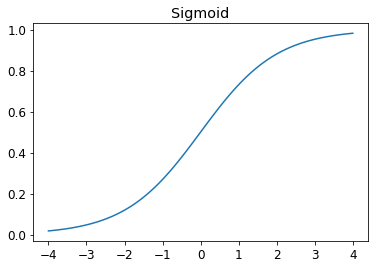

In [14]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [15]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() #squishing predictions between 0-1
    return torch.where(targets==1, 1-predictions, predictions).mean()

## Sidebar: SGD and Mini-Batches

In [16]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True) #creates minibatches
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [17]:
ds = L(enumerate(string.ascii_lowercase)) 
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [18]:
dl = DataLoader(ds, batch_size=6, shuffle=True)  #Works with tuples as well
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## End Sidebar

## Creating and testing with our own batch first
Before we go further, why don't we simulate what takes place with our own minibatch. 

### P0: Get batch

In [22]:
#Create batch
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [29]:
linear1??

### P1: Initialize parameters

In [30]:
#Get pred
preds = linear1(batch) #Get pred (initialize weights)
preds

tensor([[11.6180],
        [ 9.0489],
        [-2.4524],
        [-2.5197]], grad_fn=<AddBackward0>)

### P2: Calc loss

In [31]:
#Calc loss
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4616, grad_fn=<MeanBackward0>)

In [32]:
mnist_loss??

### P3: Calc grad

In [33]:
#Calc grad
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0057), tensor([-0.0355]))

## Put the above into a single func
We can take everything we did above and make a simple function encompassing it

In [34]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

## How to do an epoch
To do an epoch, we just need to grab each minibatch from the dataset, call calc_grad, and then step the weights. 

In [35]:
def train_epoch(model, lr, params):
    for xb,yb in dl: #get x and y batch
        calc_grad(xb, yb, model) #Calc grad
        
        for p in params: 
            p.data -= p.grad*lr #Update/take a step
            p.grad.zero_() #Set grad to zero

In [36]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [False]])

## How to calc accuracy
Accuracy is another function we need. Using the function below we can determine the performance of the model. Here, anytime the prediction is pos greater than .5 (Where pred was pos), it is correct.

In [40]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5).float() == yb  #.5 because sigmoid(0) = .5
    return correct.float().mean()

In [41]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [42]:
#Simple function that calls batch_acc per valid batch set
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [43]:
validate_epoch(linear1)

0.5484

## Putting everything togather
Below we initialize the weights, create a dataloader, train, and test

In [19]:
#get initial weights and bias
weights = init_params((28*28,1))
bias = init_params(1)

In [20]:
dl = DataLoader(dset, batch_size=256) #create minibatches

#We can grab the first batch and take a look at it
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [21]:
valid_dl = DataLoader(valid_dset, batch_size=256) #Create minibatch for validation set

In [111]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.637

In [112]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1))

0.791
0.8925
0.9315
0.9476
0.9515
0.9579
0.9637
0.9652
0.9667
0.9672
0.9677
0.9701
0.9706
0.9711
0.9725
0.9735
0.9735
0.974
0.974
0.9745


> Congratulation you have created ur official ML model from scratch!

## Let's now optimize what we did above

In [115]:
                      #Weights #Bias
linear_model = nn.Linear(28*28,1) #Does exactly what out funtion linear1 does and initialzes our parameters for us

In [116]:
 #Viewing the parameters
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [118]:
class BasicOptim:
    def __init__(self,params,lr): 
        self.params = list(params)
        self.lr = lr
 
    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

In [119]:
opt = BasicOptim(linear_model.parameters(), lr)

In [120]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [121]:
validate_epoch(linear_model)

0.3794

In [122]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [123]:
train_model(linear_model, 20)

0.4932 0.7476 0.8511 0.9155 0.9346 0.9482 0.9555 0.9629 0.9658 0.9673 0.9707 0.9722 0.9736 0.9751 0.9761 0.9766 0.9775 0.9775 0.9785 0.9785 

## Can further optimize by using FastAI ToolKit

In [124]:
linear_model = nn.Linear(28*28,1) #fastAI
opt = SGD(linear_model.parameters(), lr) #fastAI
train_model(linear_model, 20)

0.4932 0.7393 0.8613 0.9175 0.9365 0.9497 0.957 0.9634 0.9663 0.9673 0.9702 0.9727 0.9736 0.9751 0.9761 0.9766 0.9775 0.978 0.978 0.979 

## Finally, the most simplest way

In [126]:
dls = DataLoaders(dl, valid_dl) #NOT dataLoader, this class stores away the train and valid data into a single obj

In [127]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [128]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636365,0.503465,0.495584,00:00
1,0.521433,0.170448,0.864082,00:00
2,0.191138,0.189521,0.824828,00:00
3,0.083866,0.109406,0.910697,00:00
4,0.044337,0.079229,0.932777,00:00
5,0.028900,0.063259,0.947007,00:00
6,0.022547,0.053348,0.954367,00:00
7,0.019723,0.046764,0.961727,00:00
8,0.018294,0.042152,0.965653,00:00
9,0.017439,0.038766,0.967615,00:00


> I hope you now feel comfortable creating from scratch as well as using FastAI ToolKit where possible

## Adding a Nonlinearity
We can improve our model by adding some nonlinearity to it. So far we have been using a simple linear classifier. A linear classifier is very constrained. To make it a perform better, we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

In [129]:
def simple_net(xb): 
    res = xb@w1 + b1 #Linear func
    res = res.max(tensor(0.0)) #Activation func: ReLU
    res = res@w2 + b2 #Linear func
    return res

> This is all you need to change to implement nonlinearity. Before we were using linear1. Compare this to that.

In [130]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

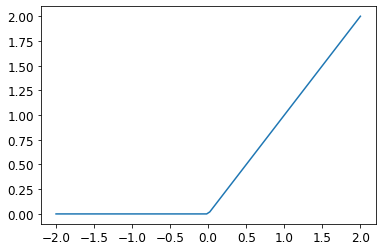

In [131]:
plot_function(F.relu)

In [134]:
#Can use sequential method to create nonlinearity
simple_net = nn.Sequential(
    nn.Linear(28*28,30), #30 sets of weights
    nn.ReLU(),
    nn.Linear(30,1) #convert back into 1 set of weights
)

In [135]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [136]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.324376,0.404988,0.505888,00:00
1,0.150483,0.233413,0.803238,00:00
2,0.083043,0.117188,0.912169,00:00
3,0.054295,0.078788,0.940628,00:00
4,0.040957,0.061365,0.956330,00:00
5,0.034142,0.051610,0.962709,00:00
6,0.030232,0.045451,0.965653,00:00
7,0.027697,0.041252,0.967125,00:00
8,0.025878,0.038205,0.968106,00:00
9,0.024475,0.035891,0.970069,00:00


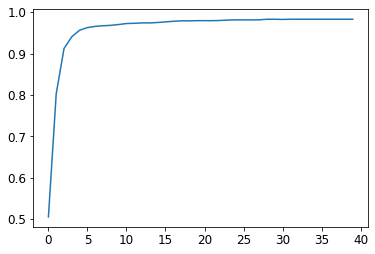

In [137]:
plt.plot(L(learn.recorder.values).itemgot(2));

## Sidebar: Now that we have trained our model, we can view its parameters

In [139]:
m = learn.model
m

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [140]:
w, b = m[0].parameters()

In [141]:
w.shape

torch.Size([30, 784])

In [ ]:
w[0].view(28,28)

<AxesSubplot:>

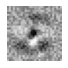

In [147]:
show_image(w[2].view(28,28))

> Seems like this neuron was looking for curves

### Going Deeper - Using ResNet
FastAI has various resnets anyone can use. Lets see how that compares to our learner.

In [148]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1) 

#Thats insane

epoch,train_loss,valid_loss,accuracy,time
0,0.132423,0.036220,0.995093,00:17


> Out preformed our model in a single epoch! Guess we still have a lot more to learn :)

## Questionnaire

1. **How is a grayscale image represented on a computer? How about a color image?**  
Image on the computer are represented by a number value, where 0=white, 255=black, and the grayscale inbetween.  
A grayscale image is rank 2 (No color channels)  
A color image is rank 3 (Has the 3 color channels, RGB)
1. **How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?**  
Files are split into train, valid, labels. This makes it easier as the training and validation set have already been presplit for for.
1. **Explain how the "pixel similarity" approach to classifying digits works.**  
This is similer to the Nearest neighbors approach, where one compare each test image with all training images. Only here, the image being compared to is an average of all the training images. Then using a distance metric we can find the abs difference between the images to identify it. 
1. **What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.** 
A python condensing technique used with for-loop.  

```python
l = [i for i in range(20)]
oddList = [i**2 for i in l if i%2 != 0]
```
1. **What is a "rank-3 tensor"?**  
A 3 dimensional tensor (Also known as a volumn).
1. **What is the difference between tensor rank and shape? How do you get the rank from the shape?**  
Rank refers to the number of dimensions in a tensor  
Shape is the size of each dimension of a tensor  
  
  Taking the len(shape) = rank
1. **What are RMSE and L1 norm?**  
Loss functions
1. **How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?**  
Broadcasting
1. **Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.**  
```python
t = tensor(list(range(1,10))).view(3,3)
t[1:,0:2]
```
1. **What is broadcasting?**  
A technique of applying an operation onto all values within an object, often, regardless of tensor (Exceptions do apply).  
1. **Are metrics generally calculated using the training set, or the validation set? Why?**  
Validation set as it contains unseen data. 
1. **What is SGD?**  
Optimization algorithm. This is what causes the loss to decrease as it steps/updates the parameters. 
1. **Why does SGD use mini-batches?**  
Minibatches are faster and more efficient on GPU. Also, they gradient is calculated more appropriately as doing it across the entire batch could cause unstable and imprecise gradients. 
1. **What are the seven steps in SGD for machine learning?**  
Initialize parameters  
Compute perdiction  
Get loss  
Get gradients  
Update wieghts  
Repeat  
Stop
1. **How do we initialize the weights in a model?**  
Randomly
1. **What is "loss"?**  
A metric used by the computer to determine its performance
1. **Why can't we always use a high learning rate?**  
Stepping to far can cause the model to increase loss or bounce and diverge
1. **What is a "gradient"?**  
Slope. This tell us how much we have to change each weight to make our model better.
1. **Do you need to know how to calculate gradients yourself?**  
No
1. **Why can't we use accuracy as a loss function?**  
A loss function needs to change as the weights are being adjusted. Accuracy only changes if the predictions of the model changes. 
1. **Draw the sigmoid function. What is special about its shape?** 
![](https://forums.fast.ai/uploads/default/original/3X/1/1/11fa5da9a15e9b4db282ff9bc1f8237073173e7d.png)  
Squishes all values between 0-1
1. **What is the difference between a loss function and a metric?**  
The loss function is understood by the computer, while a metric is understood by us humans.
1. **What is the function to calculate new weights using a learning rate?**  
The optimizer step function (Ex: SGD).
1. **What does the `DataLoader` class do?**  
Creates minibatches
1. **Write pseudocode showing the basic steps taken in each epoch for SGD.**  
```python
for x,y in data:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    
    for p in self.params:
        p -= parameters.grad * lr
        p.grad = None
```
1. **Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?**  
```python
def func(l1,l2):
    return list(zip(l1,l2))
```
1. **What does `view` do in PyTorch?**  
Reshapes tensor
1. **What are the "bias" parameters in a neural network? Why do we need them?**  
So that the gradient isnt set to 0 during the first iteration.
1. **What does the `@` operator do in Python?**  
Matrix multi
1. **What does the `backward` method do?**  
Calculated gradients
1. **Why do we have to zero the gradients?**  
PyTorch remembers the previously stored gradients
1. **What information do we have to pass to `Learner`?**  
dataset (DataLoaders), model (Ex:  nn.Linear), opt func (Ex: SGD), loss func (Ex: mnist_loss), metric(Optional)
1. **Show Python or pseudocode for the basic steps of a training loop.**  
```python
    def train_epoch(model,lr,params):
        for x,y in dl:
            calc_grad(x,y,model)

        for p in self.params:
            p -= parameters.grad * lr
            p.grad = None

    for i in range(epochs):
        train_epoch(model, lr, params)
```
    
1. **What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.**  
Activation function
1. **What is an "activation function"?**  
The purpose of an activation function is to add non-linearity to the model. 
1. **What's the difference between `F.relu` and `nn.ReLU`?**  
F.relu is a Python function
nn.ReLU is a PyTorch module (So part of a class)
1. **The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?**  
There are performance benefits to using more than one nonlinearity

### Further Research

1. **Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.**
1. **Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.**  
Completed, see here: https://usama280.github.io/PasteBlogs/